In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import pmdarima as pm
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from sklearn.preprocessing import RobustScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

from src.utils.load_dataframe import load_time_series_60min


In [2]:
# Load the dataset
df = load_time_series_60min()
# Convert index to datetime explicitly to ensure correct format
df.index = pd.to_datetime(df.index, utc=True)
df_numeric = df.select_dtypes(include=[np.number]) # select numeric columns only (exclude datetime)
df = df_numeric.resample('D').mean() # Resample to daily frequency and take the mean value for the day
print("Timestamp datatype:", df.index.dtype)  # Should show datetime64

Timestamp datatype: datetime64[ns, UTC]


In [3]:
# Select the target variable and exogenous variables
target_column:str = 'DE_load_actual_entsoe_transparency'
# Adjusted exogenous variables based on available columns
exogenous_variables:list[str] = [
'DE_solar_generation_actual',    # Solar generation for Germany
# 'DE_wind_onshore_generation_actual',  # Wind generation for Germany
'FR_load_actual_entsoe_transparency',  # Load from France
'NL_load_actual_entsoe_transparency',  # Load from Netherlands
# 'AT_price_day_ahead'  # Price day ahead for Austria (as a proxy for price)
]

In [4]:
def process_data(df:DataFrame, target_column:list[str], exogenous_variables: list[str]) -> DataFrame:
    """
    Prepares the dataset by removing NaN values in the target column and interpolating missing values in exogenous variables.

    Parameters:
    df (pd.DataFrame): The input dataframe containing the time series data.
    target_column (str): The name of the target column (dependent variable).
    exogenous_variables (list of str): A list of exogenous variables (independent variables).

    Returns:
    pd.DataFrame: The processed dataframe with no NaN values in the target column and interpolated exogenous variables.
    """
    
    # Remove rows with NaN values only in the target column
    df = df[[target_column] + exogenous_variables].dropna(subset=[target_column])

    # Interpolate missing values in the exogenous variables
    df[exogenous_variables] = df[exogenous_variables].interpolate(method='time')

    # Fill any remaining NaN values at the beginning or end of the exogenous variables columns
    df[exogenous_variables] = df[exogenous_variables].bfill().ffill()
    return df


In [5]:
df = process_data(df, target_column, exogenous_variables)

# Define target and exogenous variables
y = df[target_column]
X = df[exogenous_variables]

DE_load_actual_entsoe_transparency    1.000000
DE_solar_generation_actual           -0.358442
FR_load_actual_entsoe_transparency    0.664490
NL_load_actual_entsoe_transparency    0.821234
Name: DE_load_actual_entsoe_transparency, dtype: float64


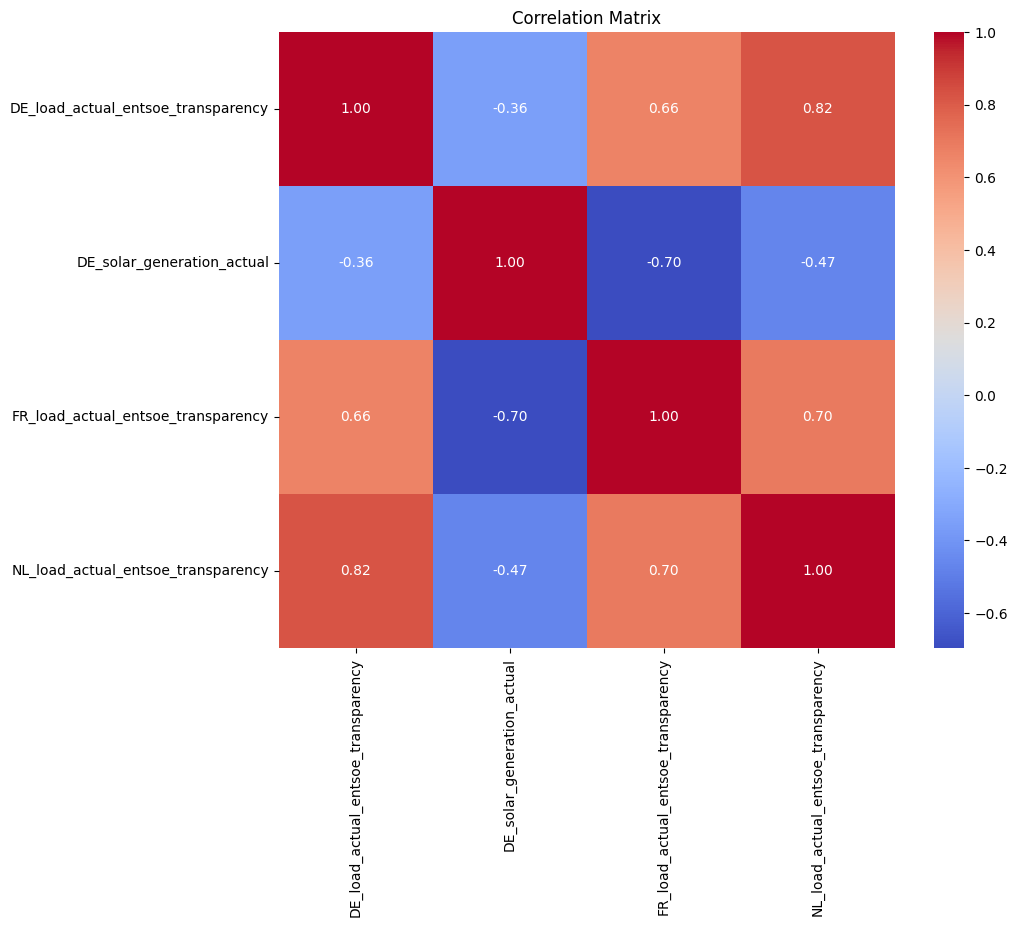

In [6]:
from src.utils.plotting import plot_correlation_matrix
correlation_matrix = df.corr()
print(correlation_matrix[target_column])
plot_correlation_matrix(correlation_matrix)

In [7]:
def check_stationarity(series: pd.Series):
    adf_result = adfuller(series)
    print(f"ADF Statistic: {adf_result[0]}")
    print(f"p-value: {adf_result[1]}")
    
    if adf_result[1] > 0.05:
        print("The series is non-stationary. Applying Box-Cox transformation...")
        series_transformed, lam = boxcox(series)
        return series_transformed, lam
    else:
        print("The series is stationary. No transformation needed.")
        return series, None

In [8]:
# Check stationarity and apply Box-Cox if needed
y_transformed, lam = check_stationarity(y)

ADF Statistic: -4.593460971848542
p-value: 0.00013280221269337063
The series is stationary. No transformation needed.


<Figure size 1000x600 with 0 Axes>

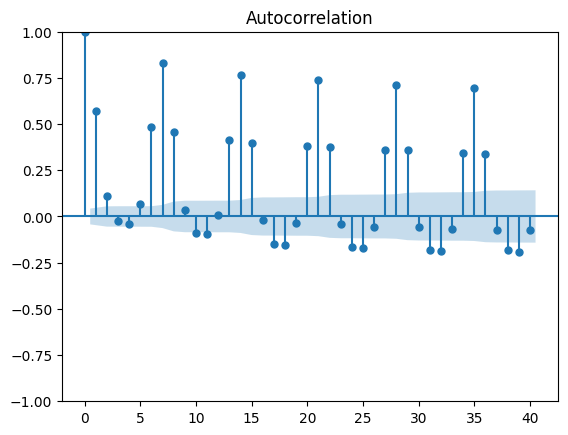

<Figure size 1000x600 with 0 Axes>

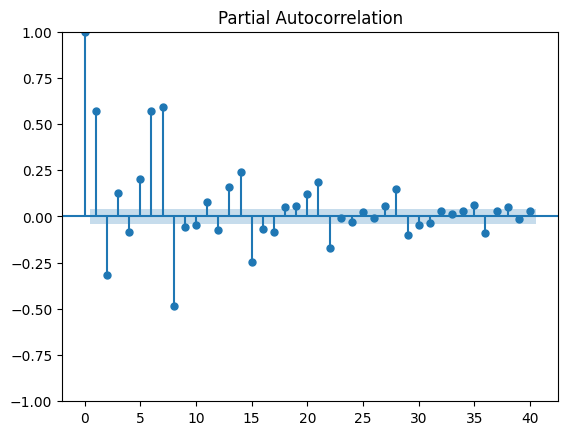

In [9]:
# Visualize ACF and PACF for the target variable
plt.figure(figsize=(10, 6))
plot_acf(y_transformed, lags=40)
plt.show()

plt.figure(figsize=(10, 6))
plot_pacf(y_transformed, lags=40)
plt.show()


In [10]:
# 3. Scaling (optional): Scale the exogenous variables if necessary
scaler = RobustScaler()


In [11]:
# Split data into train and test sets (80% train, 20% test)
print(f"Original data size: {len(df)}")
train_size = int(0.8 * len(df))
train_y, test_y = y_transformed[:train_size], y_transformed[train_size:]
train_X, test_X = X[:train_size], X[train_size:]

Original data size: 2100


In [12]:
# Scale exogenous variables after splitting
train_X_scaled = scaler.fit_transform(train_X)
test_X_scaled = scaler.transform(test_X)
print(f"Train size: {len(train_y)}, Test size: {len(test_y)}")

Train size: 1680, Test size: 420


Running auto_arima for initial parameter search...
Performing stepwise search to minimize bic
 ARIMA(0,1,0)(0,0,0)[24] intercept   : BIC=34118.309, Time=0.11 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : BIC=34097.965, Time=0.84 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : BIC=34103.353, Time=0.99 sec
 ARIMA(0,1,0)(0,0,0)[24]             : BIC=34110.884, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[24] intercept   : BIC=34123.593, Time=0.09 sec
 ARIMA(1,1,0)(2,0,0)[24] intercept   : BIC=34100.296, Time=2.53 sec
 ARIMA(1,1,0)(1,0,1)[24] intercept   : BIC=34097.600, Time=0.86 sec
 ARIMA(1,1,0)(0,0,1)[24] intercept   : BIC=34102.297, Time=0.78 sec
 ARIMA(1,1,0)(2,0,1)[24] intercept   : BIC=34105.651, Time=2.55 sec
 ARIMA(1,1,0)(1,0,2)[24] intercept   : BIC=34120.272, Time=2.65 sec
 ARIMA(1,1,0)(0,0,2)[24] intercept   : BIC=34101.831, Time=2.55 sec
 ARIMA(1,1,0)(2,0,2)[24] intercept   : BIC=34113.891, Time=2.67 sec
 ARIMA(0,1,0)(1,0,1)[24] intercept   : BIC=34088.640, Time=0.80 sec
 ARIMA(0,1,0)(0,0,1)[2

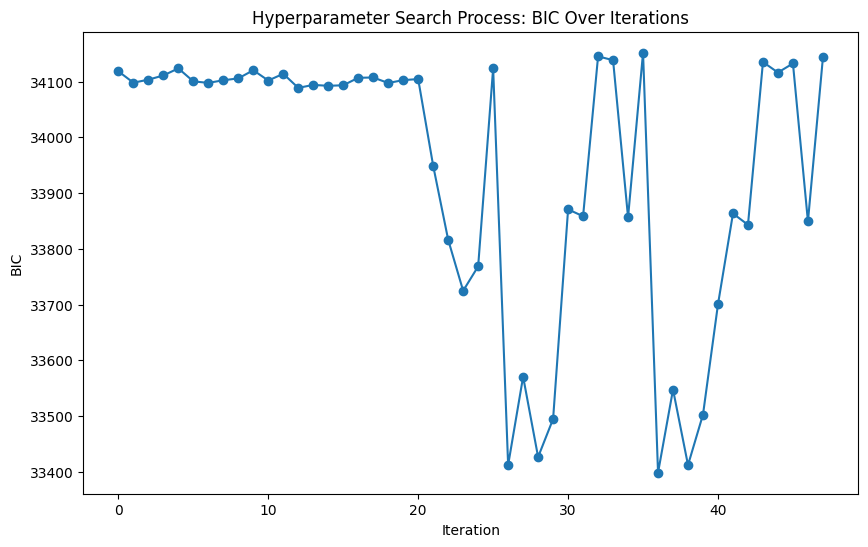

Best order: (2, 1, 1), Best seasonal order: (0, 0, 0, 24)


In [13]:
import io
import sys
import re
# Use auto_arima from pmdarima to get initial best parameters
print("Running auto_arima for initial parameter search...")
# Create a buffer to capture the console output
# Custom class to capture output and print to console
class DualWriter:
    def __init__(self, buffer, original_stdout):
        self.buffer = buffer
        self.original_stdout = original_stdout

    def write(self, text):
        self.buffer.write(text)            # Write to buffer (capture output)
        self.original_stdout.write(text)   # Print to console
        self.flush()                       # Ensure both outputs are flushed immediately

    def flush(self):
        self.buffer.flush()
        self.original_stdout.flush()

output_buffer = io.StringIO()

# Save the original stdout so we can still print to console
original_stdout = sys.stdout
# Redirect standard output to the buffer
sys.stdout = DualWriter(output_buffer, original_stdout)
auto_model = pm.auto_arima(train_y,
                            exogenous_variables=train_X_scaled,
                            seasonal=True,
                            m=24,
                            stepwise=True,
                            trace=True,
                            start_p=0, max_p=3,
                            start_q=0, max_q=3,
                            start_P=0, max_P=3,
                            start_Q=0, max_Q=3,
                            max_d=1, max_D=1,
                            suppress_warnings=True,
                            # max_order=3,
                            error_action='ignore',
                            # n_jobs=5, Parallel processing is disabled due incompatibility with Stepwise search
                            method="nm",
                            information_criterion='bic',
                        )

# Restore standard output to the console
sys.stdout = original_stdout

# Get the captured console output from the buffer
output_text = output_buffer.getvalue()

# Define a regular expression to extract BIC values and execution times from the output
bic_pattern = re.compile(r"BIC=(\d+\.\d+), Time=(\d+\.\d+) sec")

# Initialize lists to store the extracted BIC values and times
bic_values = []
times = []

# Process each line of the captured output
for line in output_text.splitlines():
    match = bic_pattern.search(line)
    if match:
        # If a match is found, append the BIC value and time to their respective lists
        bic_values.append(float(match.group(1)))
        times.append(float(match.group(2)))

# Plot the BIC values over the iterations
plt.figure(figsize=(10, 6))
plt.plot(bic_values, marker='o')
plt.title('Hyperparameter Search Process: BIC Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('BIC')
plt.show()

best_order = auto_model.order
best_seasonal_order = auto_model.seasonal_order
print(f"Best order: {best_order}, Best seasonal order: {best_seasonal_order}")

In [15]:
# Ensure consistent datetime index and timezone (if necessary)
train_y.index = pd.to_datetime(train_y.index, utc=True)
test_y.index = pd.to_datetime(test_y.index, utc=True)
# Fit SARIMAX with auto_arima parameters
sarimax_model = SARIMAX(train_y, exog=train_X_scaled, order=best_order, seasonal_order=best_seasonal_order)
sarimax_result = sarimax_model.fit(disp=False)
print(sarimax_result.summary())

                                       SARIMAX Results                                        
Dep. Variable:     DE_load_actual_entsoe_transparency   No. Observations:                 1680
Model:                               SARIMAX(2, 1, 1)   Log Likelihood              -15144.600
Date:                                Sun, 15 Sep 2024   AIC                          30303.200
Time:                                        11:29:25   BIC                          30341.181
Sample:                                    01-01-2015   HQIC                         30317.269
                                         - 08-07-2019                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          -590.3138    196.207     -3.009      0.003    -974.872    -205.756
x2 

In [16]:
# Make predictions on the test set
predictions = sarimax_result.predict(start=test_y.index[0], end=test_y.index[-1], exog=test_X_scaled)

In [17]:
if 'lam' in locals() and lam is not None:
    predictions = np.exp(np.log(predictions * lam + 1) / lam) 
    test_y = np.exp(np.log(test_y * lam + 1) / lam)


MSE: 54174544.54182395
RMSE: 7360.335898708968
MAE: 5328.43990423342
R2: -0.23970423696361554
MAPE: 9.737315619263237%
Accuracy: 45.23809523809524% with a tolerance of 5%


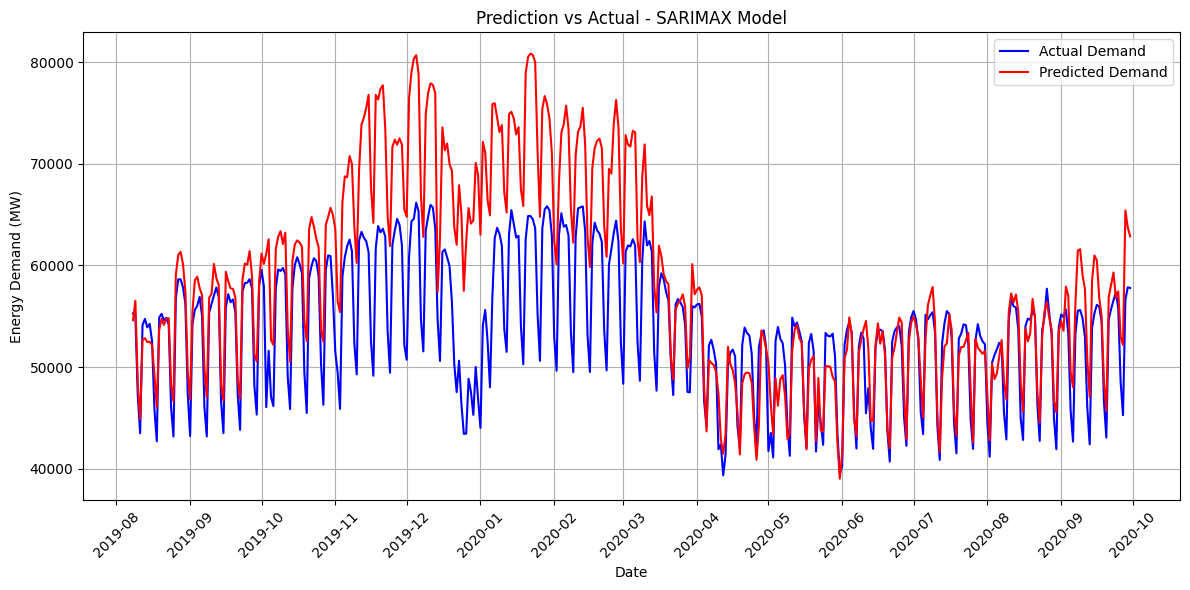

In [18]:
import importlib
import src.utils.conclusion_metrics
import src.utils.plotting
importlib.reload(src.utils.conclusion_metrics)
from src.utils.conclusion_metrics import calculate_all_metrics
importlib.reload(src.utils.plotting)
from src.utils.plotting import plot_predictions
# 7. Calculate metrics: MSE,  RMSE, MAE, R2, MAPE
test_dates = df.index[-len(test_y):]
calculate_all_metrics(y_true=test_y, y_pred=predictions)
plot_predictions( test_y, predictions, test_dates, 'Prediction vs Actual - SARIMAX Model')


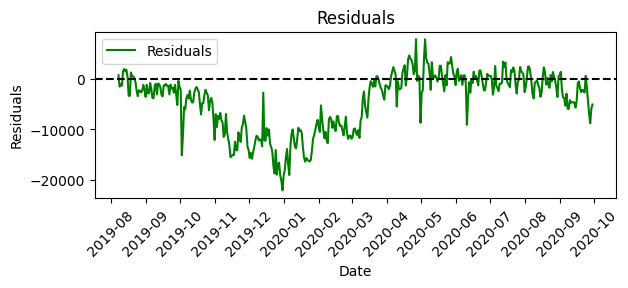

In [19]:
from src.utils.plotting import plot_residuals
residuals = test_y - predictions
plot_residuals(test_dates, residuals)